## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

#### Loading the data

In [3]:
f = open("./data/spambase.columns", "r")
headers = [line.split(":")[0] for line in f]+["class"]

df = pd.read_csv("./data/spambase.data", header=None) 
df.columns = headers
df["class"] = df["class"].replace(0,-1)

df.sample(5)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
1127,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,...,0.000,0.000,0.000,4.347,0.0,0.0,3.000,7,9,1
3396,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,...,0.000,0.000,0.000,0.000,0.0,0.0,2.500,4,5,-1
2622,0.00,0.0,0.81,0.0,1.63,0.00,0.0,0.0,0.00,0.0,...,0.000,0.000,0.000,0.000,0.0,0.0,1.090,2,12,-1
3201,0.26,0.0,0.53,0.0,0.00,0.26,0.0,0.0,0.00,0.0,...,0.000,0.039,0.000,0.000,0.0,0.0,2.646,77,172,-1
1999,0.00,0.0,0.00,0.0,0.00,0.69,0.0,0.0,0.23,0.0,...,0.033,0.000,0.033,0.000,0.0,0.0,1.554,13,143,-1


In [4]:
X = np.array(df.drop('class', axis=1))
y = df['class']
X.shape, y.shape

((4601, 57), (4601,))

#### Training a L1-regularized SVM of `sklearn`

In [5]:
n, k = X.shape
n_runs = 20
betas = np.zeros((n_runs,k))
intercepts = np.zeros(n_runs)

for seed in range(n_runs):
    clf = make_pipeline(StandardScaler(), LinearSVC(random_state=seed, max_iter=1e4, tol=1e-4, penalty='l1', dual=False, C=1.353))
    clf.fit(X,y)
    betas[seed,:] = clf.named_steps['linearsvc'].coef_
    intercepts[seed] = clf.named_steps['linearsvc'].intercept_

In [14]:
print("Score on the training set: {}".format(clf.score(X,y)))

Score on the training set: 0.9287111497500543


## Plotting coefficients of the last classifier

In [7]:
last_beta = (clf.named_steps['linearsvc'].coef_).reshape(-1)

We first find the attributes corresponding to non-zero coefficients in $\beta$ (by using an arbitrary threshold).

In [8]:
non_zero_pos_coef = (last_beta > 2e-1)
print("The positive coefficients of β correspond to:\n", list(df.columns[:-1][non_zero_pos_coef]))

The positive coefficients of β correspond to:
 ['word_freq_3d', 'word_freq_remove', 'word_freq_free', 'word_freq_000', 'word_freq_857', 'char_freq_$', 'char_freq_#', 'capital_run_length_longest']


In [9]:
non_zero_neg_coef = (last_beta < -2e-1)
print("The positive coefficients of β correspond to:\n", list(df.columns[:-1][non_zero_neg_coef]))

The positive coefficients of β correspond to:
 ['word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_lab', 'word_freq_85', 'word_freq_cs', 'word_freq_meeting', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_conference']


We then plot all the coefficients of $\beta$.

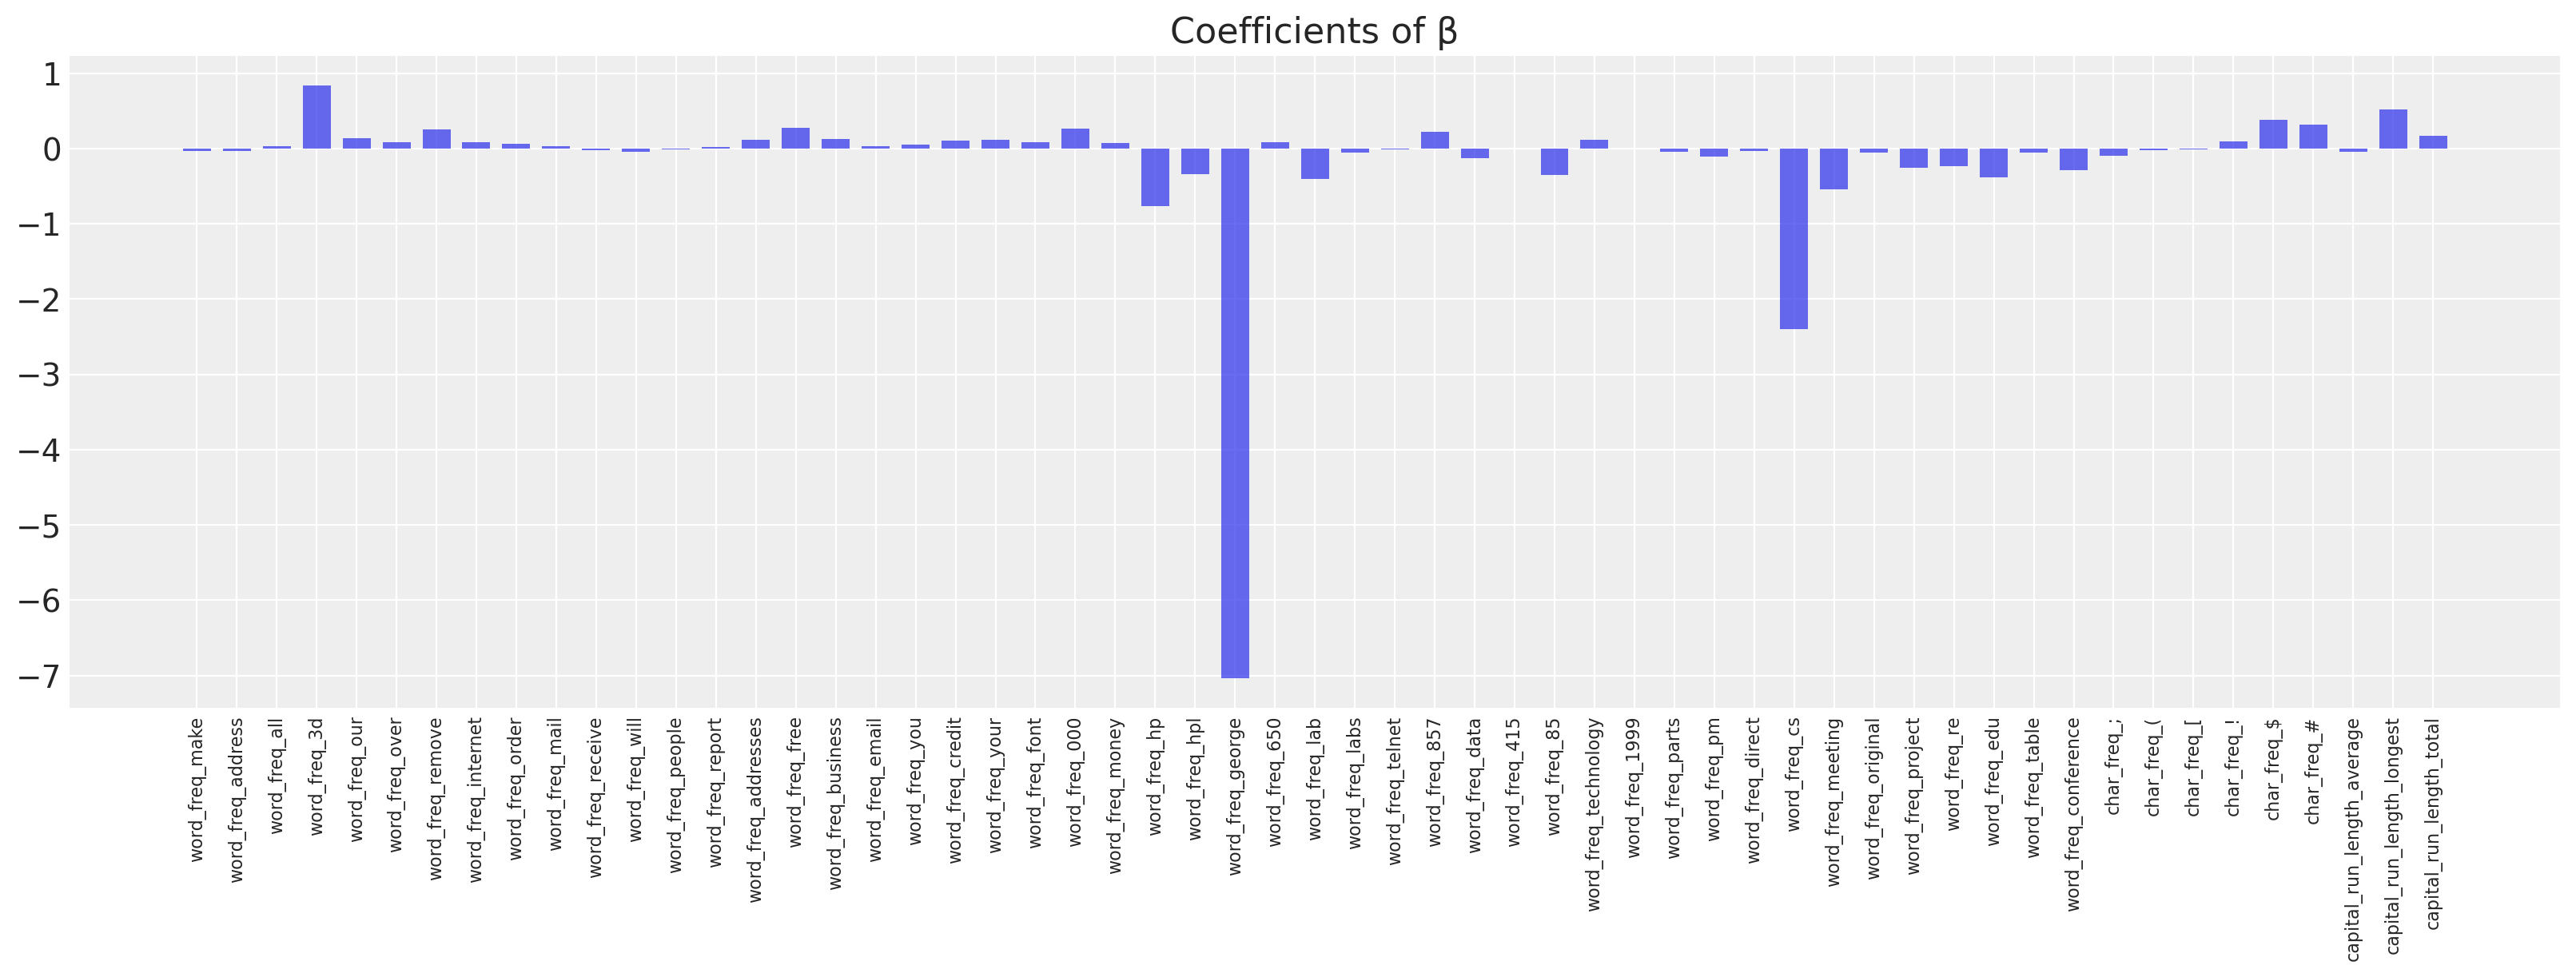

In [10]:
x = np.arange(k)
width = 0.7

fig, ax = plt.subplots(figsize=(16, 6))
bar1 = ax.bar(x, last_beta, width, alpha=.7)

ax.set_xticks(x)
ticks = df.columns[:-1]
ax.set_xticklabels(ticks, fontsize=8)
ax.set_title("Coefficients of β")

plt.xticks(rotation=90)
# plt.yscale("log")
plt.show()

## Comparing the parameters over multiple runs

For each coefficient of $\beta$, we chose to average the results from all classifiers.

In [11]:
beta_mean = list(np.mean(betas, axis=0))
intercept_mean = [np.mean(intercepts)]
means = np.array(intercept_mean+beta_mean)

We can also compute an empirical quantile interval for $\beta$, at level 95%.

In [12]:
beta_lower_bound = list(np.quantile(betas, 0.025, axis = 0))
beta_upper_bound = list(np.quantile(betas, 1-0.025, axis = 0))

intercept_lower_bound = [np.quantile(intercepts, 0.025, axis = 0)]
intercept_upper_bound = [np.quantile(intercepts, 1-0.025, axis = 0)]

lower_bound = np.array(intercept_lower_bound+beta_lower_bound)
upper_bound = np.array(intercept_upper_bound+beta_upper_bound)

err = upper_bound-lower_bound

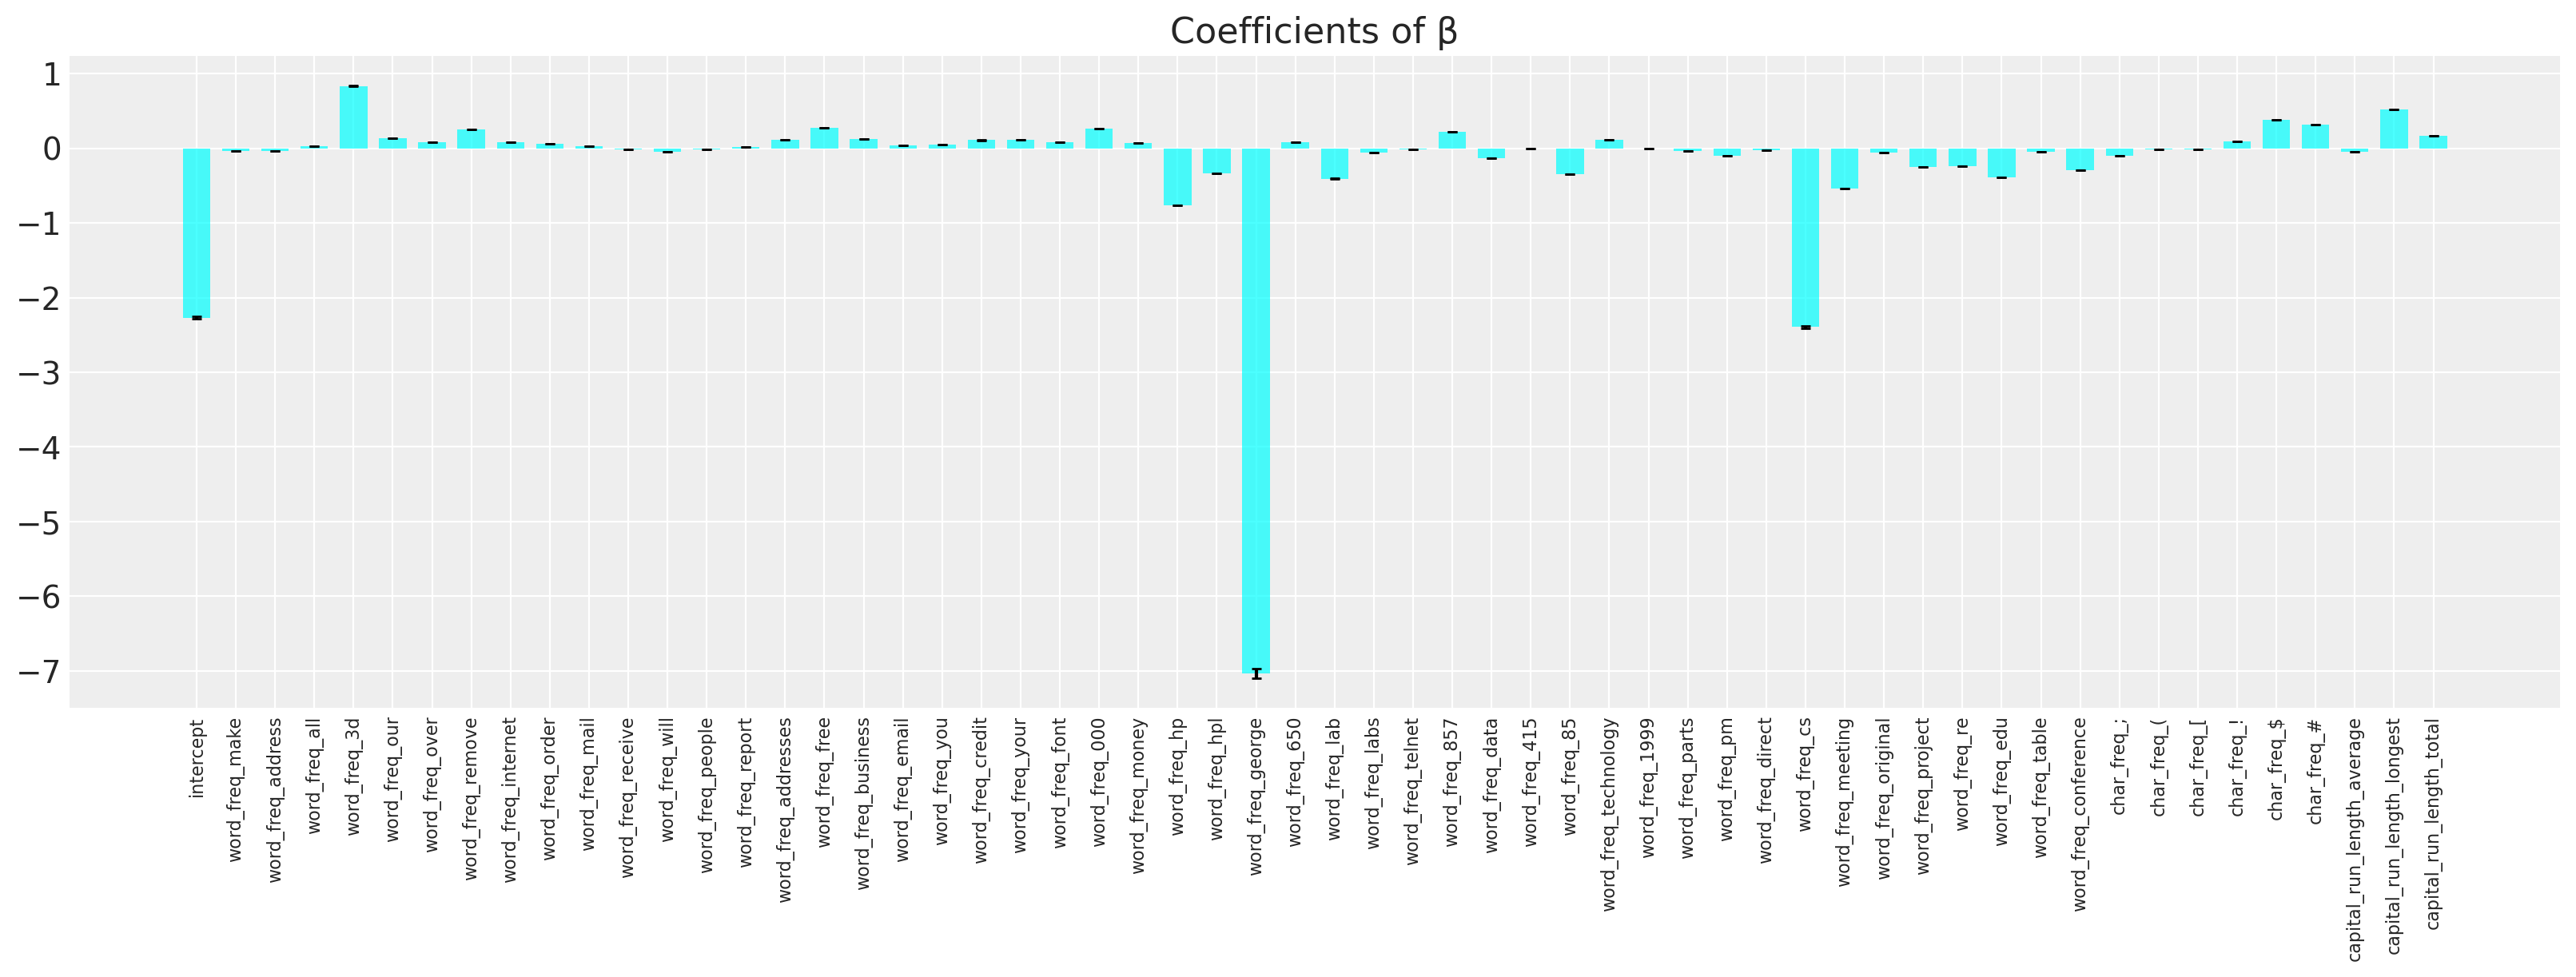

In [13]:
x = np.arange(k+1) # we add the intercept to compare with other methods
width = 0.7

fig, ax = plt.subplots(figsize=(16, 6))
bar1 = ax.bar(x, means, width, alpha=.7, yerr=err, capsize=2, color="cyan")

ax.set_xticks(x)
ticks = ["intercept"]+list(headers[:-1])
ax.set_xticklabels(ticks, fontsize=8)
ax.set_title("Coefficients of β")

plt.xticks(rotation=90)
# plt.yscale("log")
plt.show()

We clearly observe that the keywords `george` and `cs` strongly indicate that the e-mail is not a spam, as it is observed in the paper.